<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Late_fusion_Attention_based_lesion_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7l7l3q0bUXqLUQpsiTVdpPfXVodfPVOarGNKV-g2KFTeaa3IDPvBg
Mounted at /content/drive


In [3]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


## Read, Split train_val & oversample train set


In [4]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']

df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade
72,IDRiD_073,2
256,IDRiD_257,0
290,IDRiD_291,1
311,IDRiD_312,0
389,IDRiD_390,4


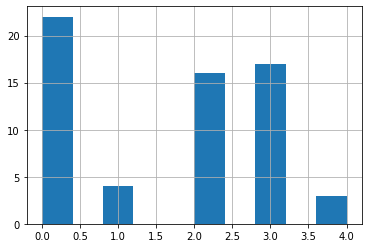

In [5]:
val_df['Retinopathy grade'].hist()

In [6]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 351


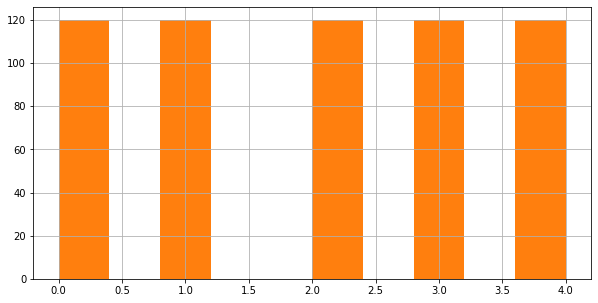

In [7]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [8]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [9]:
image_names = train_df['Image name'];
im_size = 512;

train_labels = [];
for label in train_df['Retinopathy grade']:
    #for i in range(2): # 2 times for data augmentation
    train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((len(train_labels),im_size,im_size,3))

index=0
for image_name in image_names:
    #read image
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index,:,:,:] = img

    #rot 180
    #train_images[index + 1] = np.rot90(np.rot90(img))
    index = index + 1

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  600
(600, 512, 512, 3)
(600, 5)


array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    #brightness_range=[0.,0.01],
    #zca_whitening	=True,
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(train_images)

## Read test_df


In [11]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


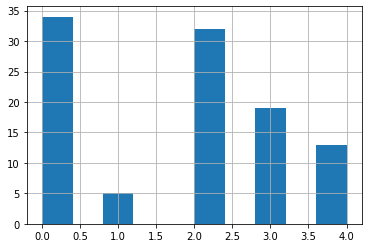

In [12]:
test_df['Retinopathy grade'].hist()

In [13]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = imread(test_images_location + '/' + image_name + ".jpg");
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 512, 512, 3)
(103, 5)


In [14]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of val set ",len(val_image_names))
im_size = 512;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);
print("max value of image ",np.max(val_images))
val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of val set  62
max value of image  255
(62, 512, 512, 3)
(62, 5)


In [15]:
val_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
val_datagen.fit(val_images)

In [16]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (600, 512, 512, 3)
train y size  (600, 5)
test x size  (103, 512, 512, 3)
test y size  (103, 5)
val x size  (62, 512, 512, 3)
val y size  (62, 5)


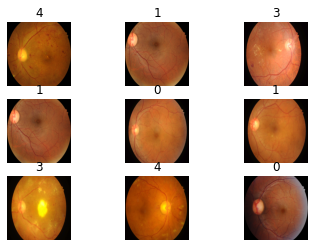

In [17]:
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(train_images[2*i+1])
  plt.title("{}".format(np.argmax(train_labels[2*i+1]))) 
  plt.axis('off')

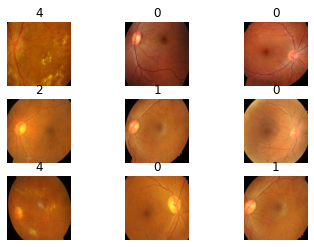

In [99]:
x=train_datagen.flow(train_images, train_labels,batch_size=9,shuffle=True)
for i,(img,lbl) in enumerate(x):
  for j in range(9):
    ax=plt.subplot(3,3,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break
del x

In [103]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB4
from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [20]:
from tensorflow.keras.models import model_from_json
def load_seg_model(model_name):
    """
    loads the pretrained seg model of given lesion
    """
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/{}.h5".format(model_name))
    # print("Loaded model from disk")

    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [21]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X


In [101]:
def build_model(num_classes,model_name):
    random.seed = 1337
    tf.seed = 1337
    tf.random.set_seed(1337)
    IMG_SIZE=380#224
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_input')(input_0)
    if model_name=='DenseNet121':
      base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    elif model_name=='EfficientNetB4':
      base_model = EfficientNetB4(include_top=False, input_tensor=input_1*255, weights="imagenet")
    ex_model=load_seg_model("model_EX")
    ma_model=load_seg_model("model_MA")
    se_model=load_seg_model("model_SE")
    he_model=load_seg_model("model_HE_1")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False
    ex_model._name='model_ex'
    ma_model._name='model_ma'
    se_model._name='model_se'
    he_model._name='model_he'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)

    #attention based input
    att=layers.Concatenate(name='concat_lesion')([les_ex,les_se,les_ma,les_he])
    #att= layers.Add(name='lesion_Add')([les_ex,les_se,les_ma,les_he])
    #att=Conv2D(3,3,strides=(1,1),padding='same')(att)
    #att=layers.BatchNormalization(name='0_bn')(att)
    #att=tf.keras.activations.sigmoid(att)
    #f_lesions=layers.Add()([input_0,att])
    
    W_g=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wg')(att)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    #input image
    W_x=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wx')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    # convolve to  attention filter
    att=layers.Add(name='additive_enhance_layer')([W_x,W_g])
    att=tf.keras.activations.relu(att, alpha=0.0, max_value=None, threshold=0)
    att=keras.layers.Conv2D(3, kernel_size=1, padding='same', strides=1)(att)
    att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))
    f_lesions=tf.keras.layers.Multiply()([att,input_0])
    #print(f_lesions.shape)
    #block1
    f_lesions=convolutional_block(f_lesions,3,(3,3,8),1,'1')
    f_lesions=convolutional_block(f_lesions,3,(8,8,16),2,'2')
    f_lesions=convolutional_block(f_lesions,3,(16,16,32),3,'3')
    f_lesions=convolutional_block(f_lesions,3,(32,32,64),4,'4')
    f_lesions=layers.GlobalAveragePooling2D()(f_lesions)
    #print(f_lesions.shape)
    top_dropout_rate = 0.2
    #f_lesions = Dense(256, activation="relu", name="last_dense_1")(f_lesions)
    #f_lesions = Dropout(top_dropout_rate, name="top_dropout_1")(f_lesions)
    #output_1 = Dense(5, activation="softmax", name="pred_1")(f_lesions)
    
    #predection_2
    x=base_model.output
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Concatenate()([x,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(NUM_CLASSES, activation="softmax", name="pred_2")(x)
  
    # Compile
    model = tf.keras.Model(input_0, x, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [121]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model=build_model(5,'EfficientNetB4')

model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled


In [122]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 19,980,081
Trainable params: 496,810
Non-trainable params: 19,483,271


In [123]:
"""plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)"""

'plot_model(\n    model,\n    to_file="model.png",\n    show_shapes=False,\n    show_dtype=False,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=48,\n)'

In [ ]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)
lr_finder = LRFinder(model)
lr_finder.find(train_images,train_labels, start_lr=1e-6, end_lr=1e-2, batch_size=6, epochs=4)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

In [124]:
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',  
                        min_delta=0.01)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=6,shuffle=True),steps_per_epoch=len(train_images) / 6,
               epochs =20, callbacks = [es,rlr],validation_data=val_datagen.flow(val_images,val_labels,batch_size=6));

Epoch 1/20
100/100 [==============================] - 198s 2s/step - loss: 1.5958 - accuracy: 0.2426 - val_loss: 1.3503 - val_accuracy: 0.3871
Epoch 2/20
100/100 [==============================] - 162s 2s/step - loss: 1.2372 - accuracy: 0.4445 - val_loss: 1.1980 - val_accuracy: 0.5806
Epoch 3/20
100/100 [==============================] - 162s 2s/step - loss: 1.0233 - accuracy: 0.6021 - val_loss: 1.2251 - val_accuracy: 0.4677
Epoch 4/20
100/100 [==============================] - 162s 2s/step - loss: 0.9745 - accuracy: 0.6406 - val_loss: 0.9869 - val_accuracy: 0.5968
Epoch 5/20
100/100 [==============================] - 162s 2s/step - loss: 1.0144 - accuracy: 0.5439 - val_loss: 1.0994 - val_accuracy: 0.5484
Epoch 6/20
100/100 [==============================] - 162s 2s/step - loss: 0.9093 - accuracy: 0.6545 - val_loss: 1.1022 - val_accuracy: 0.5161
Epoch 7/20
100/100 [==============================] - 162s 2s/step - loss: 0.8909 - accuracy: 0.6264 - val_loss: 1.0120 - val_accuracy: 0.5806

KeyboardInterrupt: ignored

In [ ]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
"""es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=8)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4,verbose=1, 
                        mode='auto',min_delta=0.01)
model.trainable=True
opt = keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.8)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=4,shuffle=True),steps_per_epoch=len(train_images) / 4,
               epochs =50, callbacks = [es,rlr],validation_data=val_datagen.flow(val_images,val_labels,batch_size=4));"""

In [ ]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

[[18  1  3  0  0]
 [ 3  0  1  0  0]
 [ 8  0  5  2  1]
 [ 6  0  4  5  2]
 [ 1  0  1  0  1]]
accuracy  0.46774193548387094  accuracy
quadratic kappa  0.4426687974430684


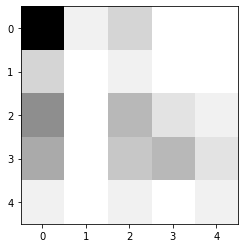

In [125]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_1=np.zeros((val_labels.shape))
#pred_y_2=np.zeros((val_labels.shape))
for i in range(7):
  pred_both=model.predict(val_images[6*i:6*i+6])
  pred_y_1[6*i:6*i+6]=pred_both
  #pred_y_2[6*i:6*i+6]=pred_both[1]
pred_y_=pred_y_1#+pred_y_2
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print("accuracy ",accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(val_labels,axis=1)))

[[27  1  4  1  1]
 [ 5  0  0  0  0]
 [ 2  2 20  7  1]
 [ 2  0  4 10  3]
 [ 2  0  3  3  5]]
0.6019417475728155  accuracy
quadratic kappa  0.6563066069215369


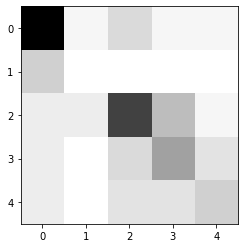

In [139]:
#preds = model.evaluate(test_images, test_labels)
#print("Loss = " + str(preds[0]))
#print("Test accuracy = " + str(preds[1]))
pred_y_=np.zeros((test_labels.shape))
for i in range(18):
  pred_y_[6*i:6*i+6]=model.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

## acc with TTA

In [136]:
test_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
test_datagen.fit(test_images)
pred_y_tta=np.zeros((102,5))
x=test_datagen.flow(test_images,test_labels,batch_size=6)
test_y_=np.zeros((102,5))

[[21  5  7  0  0]
 [ 4  0  1  0  0]
 [ 4  4 17  5  2]
 [ 1  0  6  8  4]
 [ 2  0  2  4  5]]
0.5  accuracy
quadratic kappa  0.6552315608919382


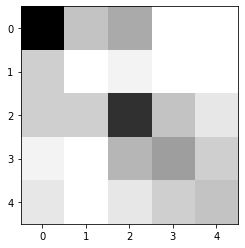

In [138]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[6*i:6*i+6]=model.predict(img)
  test_y_[6*i:6*i+6,:]=lbl
  if i==17:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

In [ ]:
#del test_datagen

## unfreeze and train

In [140]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:] == 'bn':
    layer.trainable=False
    count+=1
  if layer.name[-2:] in ['he','ex','se','ma' ]:
    layer.trainable=False
    print(layer.name," freezed")
    count+=1
print(count-4," layers of bn freezed+ 4 seg model freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

model_ex  freezed
model_se  freezed
model_ma  freezed
model_he  freezed
96  layers of bn freezed+ 4 seg model freezed
Total params: 19,980,081
Trainable params: 17,920,226
Non-trainable params: 2,059,855


In [141]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
from keras.callbacks import ModelCheckpoint
filepath="weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

opt = keras.optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=6,shuffle=True),steps_per_epoch=len(train_images) / 6,
               epochs = 20,callbacks=[early_stopping,checkpoint],validation_data=val_datagen.flow(val_images,val_labels,batch_size=6));

Epoch 1/20
100/100 [==============================] - 280s 2s/step - loss: 0.7854 - accuracy: 0.7034 - val_loss: 0.8818 - val_accuracy: 0.5806

Epoch 00001: val_accuracy improved from -inf to 0.58065, saving model to weights.01-0.58.hdf5
Epoch 2/20
100/100 [==============================] - 238s 2s/step - loss: 0.6642 - accuracy: 0.7456 - val_loss: 1.0631 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.58065
Epoch 3/20
100/100 [==============================] - 239s 2s/step - loss: 0.5879 - accuracy: 0.7717 - val_loss: 0.8029 - val_accuracy: 0.6129

Epoch 00003: val_accuracy improved from 0.58065 to 0.61290, saving model to weights.03-0.61.hdf5
Epoch 4/20
100/100 [==============================] - 239s 2s/step - loss: 0.5595 - accuracy: 0.8041 - val_loss: 0.8006 - val_accuracy: 0.6452

Epoch 00004: val_accuracy improved from 0.61290 to 0.64516, saving model to weights.04-0.65.hdf5
Epoch 5/20
100/100 [==============================] - 239s 2s/step - loss: 0.4727

ResourceExhaustedError: ignored

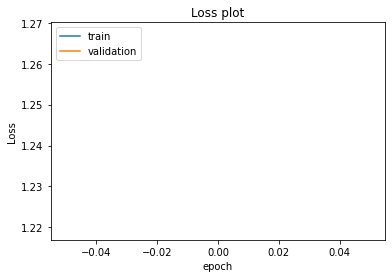

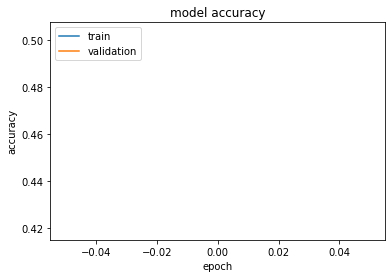

In [142]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

[[30  0  4  0  0]
 [ 5  0  0  0  0]
 [ 6  0 22  3  1]
 [ 2  0  7  9  1]
 [ 2  0  3  3  5]]
0.6407766990291263  acuracy
quadratic kappa  0.6889270095919205


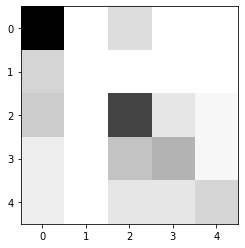

In [143]:
pred_y_=np.zeros((test_labels.shape))
for i in range(18):
  pred_y_[6*i:6*i+6]=model.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

In [ ]:
#del train_images,train_labels
#del train_datagen

In [ ]:
#del x,test_datagen,test_y_,pred_y_tta

In [93]:
test_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
test_datagen.fit(test_images)
pred_y_tta=np.zeros((102,5))
x=test_datagen.flow(test_images,test_labels,batch_size=6)
test_y_=np.zeros((102,5))

[[33  1  3  0  0]
 [ 5  1  0  0  0]
 [ 4  0 21  3  0]
 [ 0  0  5 10  2]
 [ 2  0  4  1  7]]
0.7058823529411765  accuracy
quadratic kappa  0.7760094451003542


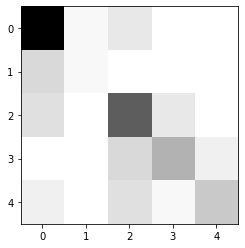

In [149]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[6*i:6*i+6]=model.predict(img)
  test_y_[6*i:6*i+6,:]=lbl
  if i==16:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

(array([37.,  0.,  6.,  0.,  0., 28.,  0., 17.,  0., 14.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

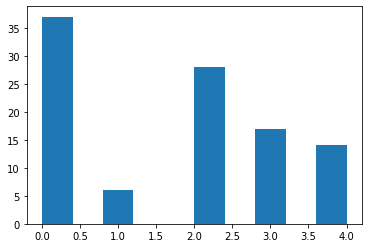

In [150]:
plt.hist(np.argmax(test_y_,axis=1))

## save model to disk

In [151]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/model_eff4_Late_fusion_Attention_based_lesion.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/model_eff4_Late_fusion_Attention_based_lesion.h5")
print("Saved model to disk")

Saved model to disk


## test on best validation model

In [154]:
model_1=build_model(5,'EfficientNetB4')
model_1.load_weights("weights.07-0.71.hdf5") 

model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled


[[28  2  4  0  0]
 [ 5  0  0  0  0]
 [ 4  4 19  4  1]
 [ 2  0  6  9  2]
 [ 2  0  3  5  3]]
0.5728155339805825  acuracy
quadratic kappa  0.6789530971699981


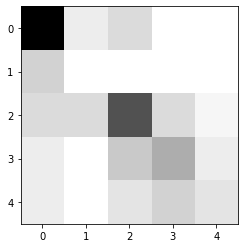

In [160]:
pred_y_=np.zeros((test_labels.shape))
for i in range(18):
  pred_y_[6*i:6*i+6]=model_1.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

[[25  6  3  0  0]
 [ 3  1  1  0  0]
 [ 3  3 22  3  0]
 [ 2  0  7  7  3]
 [ 1  0  5  2  5]]
0.5882352941176471  accuracy
quadratic kappa  0.7169929850277458


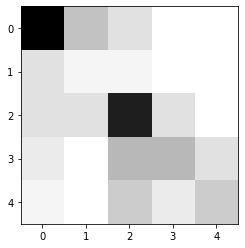

In [170]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[6*i:6*i+6]=model_1.predict(img)
  test_y_[6*i:6*i+6,:]=lbl
  if i==16:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

In [152]:
test_y_[-2:],pred_y_tta[-2:]

(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[9.57671523e-01, 4.18191217e-02, 4.65519086e-04, 3.92664915e-05,
         4.39963287e-06],
        [9.27567184e-01, 1.46416007e-02, 3.63852642e-02, 3.45239928e-03,
         1.79534964e-02]]))

In [153]:
pred_y_tta.shape

(102, 5)